
## Task 1: Symbolic Unconditioned Generation (Harmonization) ##
## Yifan Fu, Jack Lund




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import pickle
import numpy as np
import random
import os
import math
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from music21 import stream, note, chord, meter, key, tempo, duration, corpus, converter
    MUSIC21_AVAILABLE = True
    print("Music21 available - MIDI generation enabled")
except ImportError:
    print("Warning: music21 not available. MIDI generation will be disabled.")
    MUSIC21_AVAILABLE = False

print("All libraries imported successfully!")

Music21 available - MIDI generation enabled
All libraries imported successfully!


In [2]:
# 
# Config and parameter for our project
# 
class Config:
    # input data
    XML_FOLDER = "input/dataset1"     # xml files
    RAW_JSON = "input/rawdata.json"   # xml to json
    
    # model and vocab
    BASELINE_MODEL_PATH = "models/baseline_model.pth"
    BASELINE_VOCAB_PATH = "models/baseline_vocab.pkl"

    IMPROVED_MODEL_PATH = "models/improved_model.pth"
    IMPROVED_VOCAB_PATH = "models/improved_vocab.pkl"
    
    # ouput files
    MIDI_OUTPUT_DIR = "outputs/generated_chorales"   # mid file for listening
    EVAL_OUTPUT_DIR = "outputs/evaluation_results"   # save plot graphs

    # model parameters for adjusting    
    BATCH_SIZE = 32   #64
    LEARNING_RATE = 0.0005 # 0.0001
    EPOCHS = 100
    MAX_LENGTH = 128
    HIDDEN_DIM = 256
    NUM_LAYERS = 2

    WEIGHT_DECAY = 1e-5  
    GRAD_CLIP = 1.0  
    WARMUP_STEPS = 1000  
    
    # data split
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15


In [3]:
#
#  XML process
#
# Extract note names from a musical part
# Handles both single notes and chords by getting root note or first pitch.
# Returns a list of note names with octave information
def extract_notes_from_part(part):
    notes = []
    for elem in part.flat.notes:
        if isinstance(elem, note.Note):
            notes.append(elem.nameWithOctave)
        elif isinstance(elem, chord.Chord):
            root = elem.root()
            notes.append(root.nameWithOctave if root else elem.pitches[0].nameWithOctave)
    return notes

# Extract four voice parts (soprano, alto, tenor, bass) from a musical score
# Ensures exactly 4 voices are returned, filling with empty lists if needed
# Returns tuple of (soprano, alto, tenor, bass) note sequences
def extract_voices(score):
    parts = score.parts
    voices = []
    for i in range(4):
        if i < len(parts):
            voices.append(extract_notes_from_part(parts[i]))
        else:
            voices.append([])
    return voices[0], voices[1], voices[2], voices[3]

# Process a single XML music file and extract voice data
def process_xml_file(file_path):
    try:
        score = converter.parse(file_path)
        soprano, alto, tenor, bass = extract_voices(score)
        
        all_sequences = [ soprano, alto, tenor, bass]
        non_empty_sequences = [seq for seq in all_sequences if len(seq) > 0]
        
        if not non_empty_sequences:
            return None
        
        min_length = min(len(seq) for seq in non_empty_sequences)
        if min_length < 4:
            return None
        
        return {
            "filename": os.path.basename(file_path),
            "targets": {
                "soprano": soprano[:min_length] if soprano else ["N"] * min_length,
                "alto": alto[:min_length] if alto else ["N"] * min_length,
                "tenor": tenor[:min_length] if tenor else ["N"] * min_length,
                "bass": bass[:min_length] if bass else ["N"] * min_length
            }
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Convert all XML music files in the input folder to a single JSON file
def convert_xml_to_json():
    print("Converting XML files to JSON...")
    folder_path = Path(Config.XML_FOLDER)
    if not folder_path.exists():
        print(f"Error: {Config.XML_FOLDER} not found")
        return False
    
    xml_files = []
    for ext in ['*.xml', '*.musicxml', '*.mxl']:
        xml_files.extend(folder_path.glob(ext))
    
    if not xml_files:
        print(f"No XML files found in {Config.XML_FOLDER}")
        return False
    
    data = []
    for xml_file in xml_files:
        sample = process_xml_file(xml_file)
        if sample:
            data.append(sample)
    
    if data:
        os.makedirs(os.path.dirname(Config.RAW_JSON), exist_ok=True)
        with open(Config.RAW_JSON, "w", encoding='utf-8') as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print(f"Converted {len(data)} files to {Config.RAW_JSON}")
        return True
    return False

# create the folders if user don't have them
def create_folders():
    folders = [Config.MIDI_OUTPUT_DIR, Config.EVAL_OUTPUT_DIR,
               os.path.dirname(Config.IMPROVED_VOCAB_PATH),os.path.dirname(Config.BASELINE_VOCAB_PATH), os.path.dirname(Config.RAW_JSON)]
    for folder in folders:
        Path(folder).mkdir(parents=True, exist_ok=True)

# load and split data for training/validating/testing 
# return the ratioof the split
def load_and_split_data():
    with open(Config.RAW_JSON, 'r') as f:
        data = json.load(f)
    
    if isinstance(data, dict):
        data = data.get('train', data.get('data', list(data.values())[0]))
    
    train_size = int(0.7 * len(data))
    val_size = int(0.15 * len(data))
    
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    
    return train_data, val_data, test_data


In [ ]:
# Vocabulary builder for creating note-to-index mappings
# exp:  origin from input data   ->  C4  →  D4  →  E4  →  F4  →  G4
#       data be saved into vacab ->   4  →   5  →   6  →   7  →   8   
class VocabBuilder:
    def __init__(self):
        self.note_to_idx = {}
        self.idx_to_note = {}
        
    # Build note vocabulary from training data
    def build_vocab(self, data):
        print("Building vocabulary...")
        all_notes = []
        
        for sample in data:
            for voice in ['soprano', 'alto', 'tenor', 'bass']:
                all_notes.extend(sample['targets'][voice])
        
        note_counter = Counter(all_notes)
        print(f"Found {len(note_counter)} unique notes")
        
        # Add special tokens
        special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']
        vocab_notes = special_tokens + list(note_counter.keys())
        
        # core for changing notes into numbers
        self.note_to_idx = {note: idx for idx, note in enumerate(vocab_notes)}
        self.idx_to_note = {idx: note for note, idx in self.note_to_idx.items()}
        
        print(f"Note vocabulary size: {len(self.note_to_idx)}")
    
    # Encode note sequence to index sequence
    def encode_sequence(self, sequence, vocab_dict):
        return [vocab_dict.get(item, vocab_dict['<UNK>']) for item in sequence]
    # Decode index sequence to note sequence
    def decode_sequence(self, indices, vocab_dict):
        return [vocab_dict.get(idx, '<UNK>') for idx in indices]
        
    def save_vocab(self, path):
        vocab_data = {
            'note_to_idx': self.note_to_idx,
            'idx_to_note': self.idx_to_note
        }
        with open(path, 'wb') as f:
            pickle.dump(vocab_data, f)
        print(f"Vocabulary saved to {path}")

# #  Choir dataset class for PyTorch training
class ChoirDataset(Dataset):
    # Initialize the dataset
    def __init__(self, data, vocab_builder, max_length=128):
        self.data = data
        self.vocab_builder = vocab_builder
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    # Get data sample at specified index
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        # Encode targets only (no melody/chord inputs)  ->unconfitioned
        targets = {}
        original_length = len(sample['targets']['soprano'])  
        
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            sequence = sample['targets'][voice]
            
            # Add start and end tokens
            sequence_with_tokens = ['<START>'] + sequence + ['<END>']
            encoded = self.vocab_builder.encode_sequence(sequence_with_tokens, self.vocab_builder.note_to_idx)
            
            # Pad or truncate
            if len(encoded) > self.max_length:
                encoded = encoded[:self.max_length]
            else:
                encoded.extend([self.vocab_builder.note_to_idx['<PAD>']] * (self.max_length - len(encoded)))
            
            targets[voice] = torch.tensor(encoded, dtype=torch.long)
        
        actual_length = min(original_length + 2, self.max_length)  # +2 for start/end tokens
        
        return {
            'targets': targets,
            'lengths': actual_length  
        }

# Batch data collation 
def collate_fn(batch):
    targets = {}
    lengths = []
    
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        targets[voice] = torch.stack([item['targets'][voice] for item in batch])
    lengths = torch.tensor([item['lengths'] for item in batch], dtype=torch.long)
    
    return {
        'targets': targets,
        'lengths': lengths
    }


In [5]:
#
# Three types of Models
#

# Deep four-part choir model (Baseline Model)
class DeepChoirModel(nn.Module):
    # Initialize deep choir model
    def __init__(self, note_vocab_size, hidden_dim=256, num_layers=2):
        super().__init__()
        self.note_vocab_size = note_vocab_size
        self.hidden_dim = hidden_dim
        
        # Note embedding
        self.note_embed = nn.Embedding(note_vocab_size, hidden_dim)
        
        # Shared encoder (processes previous context)
        self.encoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        
        # Voice-specific decoders
        self.decoders = nn.ModuleDict()
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            self.decoders[voice] = nn.Sequential(
                nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1),
                nn.Linear(hidden_dim, note_vocab_size)
            )
    # Deep model forward pass
    def forward(self, input_sequences):
        outputs = {}
        
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            # Embed input
            embedded = self.note_embed(input_sequences[voice])
            
            # Encode context
            encoded, _ = self.encoder(embedded)
            
            # Decode for this voice
            if isinstance(self.decoders[voice], nn.Sequential):
                # Handle the sequential case
                lstm_layer = self.decoders[voice][0]
                linear_layer = self.decoders[voice][1]
                decoded, _ = lstm_layer(encoded)
                outputs[voice] = linear_layer(decoded)
            else:
                outputs[voice] = self.decoders[voice](encoded)
        return outputs 
    
# CNN model (Improved Model with best performance)
class CNNChoirModel(nn.Module):
    # Initialize deep choir model
    def __init__(self, note_vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.note_vocab_size = note_vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.note_embed = nn.Embedding(note_vocab_size, embed_dim)
        
        # 1D conv layers to capture local patterns
        self.conv1 = nn.Conv1d(embed_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        
        self.dropout = nn.Dropout(0.3)
        
        # output heads for each voice part
        self.output_heads = nn.ModuleDict()
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            self.output_heads[voice] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim // 2, note_vocab_size)
            )
        
        self.apply(self._init_weights)
    # Initialize model weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.1)
        elif isinstance(module, nn.Conv1d):
            torch.nn.init.kaiming_normal_(module.weight)
    # CNN model forward pass
    def forward(self, input_sequences):
        outputs = {}
        
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            x = input_sequences[voice]  # (batch_size, seq_len)
            
            embedded = self.note_embed(x)  # (batch_size, seq_len, embed_dim)
            
            # transpose for 1D conv: (batch_size, embed_dim, seq_len)
            x = embedded.transpose(1, 2)
            
            x = F.relu(self.conv1(x))
            x = self.dropout(x)
            
            x = F.relu(self.conv2(x))
            x = self.dropout(x)
            
            x = F.relu(self.conv3(x))
            x = self.dropout(x)
            
            # back to (batch_size, seq_len, hidden_dim)
            x = x.transpose(1, 2)
            
            outputs[voice] = self.output_heads[voice](x)
        
        return outputs
    
# N-gram Model (Improved Model)
class NgramModel(nn.Module):
    # Initialize deep choir model
    def __init__(self, note_vocab_size, n=4, embed_dim=64):
        super().__init__()
        self.note_vocab_size = note_vocab_size
        self.n = n
        self.embed_dim = embed_dim
        
        self.note_embed = nn.Embedding(note_vocab_size, embed_dim)
        
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim * n, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, note_vocab_size)
        )
        
        self.apply(self._init_weights)
    # Initialize model weights
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.1)
    # N-gram model forward pass
    def forward(self, input_sequences):
        outputs = {}
        
        for voice in ['soprano', 'alto', 'tenor', 'bass']:
            x = input_sequences[voice]  # (batch_size, seq_len)
            batch_size, seq_len = x.shape
            
            embedded = self.note_embed(x)  # (batch_size, seq_len, embed_dim)
            
            voice_outputs = []
            
            for i in range(seq_len):
                # get n-gram context
                start = max(0, i - self.n + 1)
                context = embedded[:, start:i+1, :]
                
                # pad to fixed length
                context_len = context.shape[1]
                if context_len < self.n:
                    padding = torch.zeros(batch_size, self.n - context_len, self.embed_dim, device=x.device)
                    context = torch.cat([padding, context], dim=1)
                
                context_flat = context.view(batch_size, -1)
                output = self.predictor(context_flat)
                voice_outputs.append(output.unsqueeze(1))
            
            outputs[voice] = torch.cat(voice_outputs, dim=1)
        
        return outputs


In [ ]:
# Compute basic cross-entropy loss
def compute_basic_loss(outputs, targets, lengths, criterion):
    total_loss = 0
    voice_weights = {'soprano': 1.0, 'alto': 1.0, 'tenor': 1.0, 'bass': 1.2}
    
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        pred = outputs[voice].view(-1, outputs[voice].size(-1))
        target = targets[voice].reshape(-1) 
        
        # Create mask for valid positions
        mask = torch.zeros_like(target, dtype=torch.bool)
        for i, length in enumerate(lengths):
            mask[i * outputs[voice].size(1):(i * outputs[voice].size(1) + length)] = True
        
        pred_masked = pred[mask]
        target_masked = target[mask]
        
        if len(target_masked) > 0:
            voice_loss = criterion(pred_masked, target_masked)
            total_loss += voice_weights[voice] * voice_loss
    
    return total_loss / len(voice_weights)

# Compute music theory constraint loss -- Apply constraints based on voice spacing and music theory rules
def compute_music_constraint_loss(outputs, targets, lengths, vocab_builder):
    """Music theory constraint loss for unconditioned generation"""
    device = outputs['soprano'].device
    constraint_loss = 0
    
    # Voice spacing constraints
    for i in range(len(lengths)):
        length = lengths[i]
        
        for t in range(1, min(length, outputs['soprano'].size(1))):
            # Get prediction probabilities for each voice
            soprano_probs = torch.softmax(outputs['soprano'][i, t], dim=-1)
            alto_probs = torch.softmax(outputs['alto'][i, t], dim=-1)
            tenor_probs = torch.softmax(outputs['tenor'][i, t], dim=-1)
            bass_probs = torch.softmax(outputs['bass'][i, t], dim=-1)
            
            # Simple voice spacing constraint
            interval_penalty = compute_interval_penalty(
                soprano_probs, alto_probs, tenor_probs, bass_probs, vocab_builder
            )
            constraint_loss += interval_penalty
    
    return constraint_loss / (len(lengths) * max(1, torch.mean(lengths.float()).item()))

# Compute voice spacing penalty  -- Avoid voices being too close by calculating probability distribution similarities
def compute_interval_penalty(soprano_probs, alto_probs, tenor_probs, bass_probs, vocab_builder):
    similarities = []
    probs_list = [soprano_probs, alto_probs, tenor_probs, bass_probs]
    
    for i in range(len(probs_list)):
        for j in range(i+1, len(probs_list)):
            # Calculate probability distribution similarity
            similarity = torch.sum(probs_list[i] * probs_list[j])
            similarities.append(similarity)
    
    # Penalize overly similar voices
    avg_similarity = torch.mean(torch.stack(similarities))
    penalty = torch.relu(avg_similarity - 0.3)
    
    return penalty

# Compute musical coherence loss
def compute_coherence_loss(outputs, lengths):
    coherence_loss = 0
    
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        voice_output = outputs[voice]
        
        for i in range(len(lengths)):
            length = min(lengths[i], voice_output.size(1))
            if length <= 1:
                continue
            
            # Calculate smoothness between adjacent time steps
            for t in range(length - 1):
                current_probs = torch.softmax(voice_output[i, t], dim=-1)
                next_probs = torch.softmax(voice_output[i, t+1], dim=-1)
                
                # Calculate KL divergence between adjacent steps
                kl_div = torch.sum(current_probs * torch.log(current_probs / (next_probs + 1e-8) + 1e-8))
                coherence_loss += kl_div
    
    return coherence_loss / (len(lengths) * 4)

# Compute comprehensive improved loss function
def compute_improved_loss(outputs, targets, lengths, criterion, vocab_builder):
   
    
    # Baseline loss
    base_loss = compute_basic_loss(outputs, targets, lengths, criterion)
    
    # Music constraint loss
    music_loss = compute_music_constraint_loss(outputs, targets, lengths, vocab_builder)
    
    # Coherence loss
    coherence_loss = compute_coherence_loss(outputs, lengths)
    
    # Combined loss
    total_loss = base_loss + 0.1 * music_loss + 0.05 * coherence_loss
    
    return total_loss, {
        'base_loss': base_loss.item(),
        'music_loss': music_loss.item(),
        'coherence_loss': coherence_loss.item(),
        'total_loss': total_loss.item()
    }


In [7]:
#
# Train Model
#

# Trainer for LSTM（baseline） models
class BaselineTrainer:
    # Simple trainer for baseline model
    def __init__(self, model, vocab_builder, device):
        self.model = model
        self.vocab_builder = vocab_builder
        self.device = device
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
        
        self.training_history = {
            'train_losses': [],
            'val_losses': []
        }
    # Train one baseline epoch
    def train_epoch(self, train_loader):
        # Train one epoch with basic setup
        self.model.train()
        epoch_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
            lengths = batch['lengths'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # For Task 1- use shifted targets as input (teacher forcing)
            inputs = {}
            for voice in ['soprano', 'alto', 'tenor', 'bass']:
                # Input is target shifted by one position
                inputs[voice] = targets[voice][:, :-1]  # Remove last token
                targets[voice] = targets[voice][:, 1:]   # Remove first token
            
            outputs = self.model(inputs)
            loss = compute_basic_loss(outputs, targets, lengths-1, self.criterion)
            
            loss.backward()
            self.optimizer.step()
            epoch_losses.append(loss.item())
            
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}: Loss {loss.item():.4f}")
        
        return np.mean(epoch_losses)
    
    # Validate model performance
    def validate(self, val_loader):
        """Simple validation"""
        self.model.eval()
        val_losses = []
        
        with torch.no_grad():
            for batch in val_loader:
                targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
                lengths = batch['lengths'].to(self.device)
                
                # Same teacher forcing approach
                inputs = {}
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    inputs[voice] = targets[voice][:, :-1]
                    targets[voice] = targets[voice][:, 1:]
                
                outputs = self.model(inputs)
                loss = compute_basic_loss(outputs, targets, lengths-1, self.criterion)
                val_losses.append(loss.item())
        
        return np.mean(val_losses)
    
    # Complete model training process
    # Execute multiple training epochs, save best model, support early stopping
    def train_model(self, train_loader, val_loader, save_path):
        """Basic training loop"""
        print("Starting baseline training...")
        best_val_loss = float('inf')
        
        for epoch in range(Config.EPOCHS):
            print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
            
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            self.training_history['train_losses'].append(train_loss)
            self.training_history['val_losses'].append(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'epoch': epoch,
                    'val_loss': val_loss,
                    'train_loss': train_loss,
                    'training_history': self.training_history,
                    'model_config': {
                        'note_vocab_size': len(self.vocab_builder.note_to_idx),
                        'hidden_dim': 256,
                        'num_layers': 2
                    }
                }, save_path)
                print(f"  Best model saved! Val loss: {val_loss:.4f}")
        
        print(f"\nBaseline training completed! Best validation loss: {best_val_loss:.4f}")
        return self.training_history

# Main function for training baseline model
def train_baseline_model():
    """Train baseline model from scratch"""
    print("=== Training Baseline Model ===")
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    create_folders()
    
    # Load data
    print("Loading and splitting data...")
    train_data, val_data, test_data = load_and_split_data()
    print(f"Data loaded: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    
    # Build vocabulary
    print("Building vocabulary...")
    vocab_builder = VocabBuilder()
    vocab_builder.build_vocab(train_data)
    vocab_builder.save_vocab(Config.BASELINE_VOCAB_PATH)
    print(f"Vocabulary sizes: Notes={len(vocab_builder.note_to_idx)}")
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = ChoirDataset(train_data, vocab_builder)
    val_dataset = ChoirDataset(val_data, vocab_builder)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    # Create model
    print("Initializing baseline model...")
    model = DeepChoirModel(
        note_vocab_size=len(vocab_builder.note_to_idx),
        hidden_dim=256,
        num_layers=2
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train
    trainer = BaselineTrainer(model, vocab_builder, device)
    history = trainer.train_model(train_loader, val_loader, Config.BASELINE_MODEL_PATH)
    
    print("\nBaseline model training completed!")
    return history

# Trainer for non-LSTM models
class SimpleNonLSTMTrainer:
    def __init__(self, model, vocab_builder, device):
        self.model = model
        self.vocab_builder = vocab_builder
        self.device = device
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.8, patience=3
        )
    
    # Train for one epoch
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        
        for batch_idx, batch in enumerate(train_loader):
            targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
            
            # teacher forcing
            inputs = {}
            for voice in ['soprano', 'alto', 'tenor', 'bass']:
                inputs[voice] = targets[voice][:, :-1]
                targets[voice] = targets[voice][:, 1:]
            
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs)
            
            loss = 0
            for voice in ['soprano', 'alto', 'tenor', 'bass']:
                pred = outputs[voice].reshape(-1, outputs[voice].size(-1))
                target = targets[voice].reshape(-1)
                voice_loss = self.criterion(pred, target)
                loss += voice_loss
                
                # calc accuracy
                pred_tokens = pred.argmax(dim=-1)
                mask = target != 0
                if mask.sum() > 0:
                    correct = (pred_tokens[mask] == target[mask]).sum().item()
                    total_correct += correct
                    total_tokens += mask.sum().item()
            
            loss = loss / 4  # average loss across voices
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                current_acc = total_correct / max(total_tokens, 1)
                print(f"    Batch {batch_idx}: Loss {loss.item():.4f}, Acc {current_acc:.3f}")
        
        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / max(total_tokens, 1)
        
        return avg_loss, accuracy
    
    # Validate model performance
    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        
        with torch.no_grad():
            for batch in val_loader:
                targets = {voice: seq.to(self.device) for voice, seq in batch['targets'].items()}
                
                inputs = {}
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    inputs[voice] = targets[voice][:, :-1]
                    targets[voice] = targets[voice][:, 1:]
                
                outputs = self.model(inputs)
                
                loss = 0
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    pred = outputs[voice].reshape(-1, outputs[voice].size(-1))
                    target = targets[voice].reshape(-1)
                    voice_loss = self.criterion(pred, target)
                    loss += voice_loss
                    
                    pred_tokens = pred.argmax(dim=-1)
                    mask = target != 0
                    if mask.sum() > 0:
                        correct = (pred_tokens[mask] == target[mask]).sum().item()
                        total_correct += correct
                        total_tokens += mask.sum().item()
                
                total_loss += (loss / 4).item()
        
        avg_loss = total_loss / len(val_loader)
        accuracy = total_correct / max(total_tokens, 1)
        
        return avg_loss, accuracy
    
    # Complete model training process
    # Execute multiple training epochs, save best model, support early stopping
    def train_model(self, train_loader, val_loader, save_path, epochs=15):
        print("Starting non-LSTM model training...")
        best_accuracy = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.validate(val_loader)
            
            self.scheduler.step(val_loss)
            
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} ({train_acc*100:.1f}%)")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f} ({val_acc*100:.1f}%)")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'epoch': epoch,
                    'accuracy': val_acc,
                    'model_config': {
                        'note_vocab_size': len(self.vocab_builder.note_to_idx)
                    }
                }, save_path)
                print(f"Saved best model! Accuracy: {val_acc:.3f}")
            
            # early stopping if accuracy is good enough
            if val_acc > 0.8:
                print("Reached good accuracy, stopping training!")
                break
        
        print(f"\nTraining complete! Best accuracy: {best_accuracy:.3f} ({best_accuracy*100:.1f}%)")
        return best_accuracy

# Main function for training non-LSTM models
def train_advanced_model():    
    print("=== Non-LSTM Music Generation Models ===")
    print("Choose model type:")
    print("1. CNN Model (1D convolution)")
    print("2. N-gram Model (simplest)")
    
    choice = input("Choose (1/2): ").strip()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    create_folders()
    
    # load data
    train_data, val_data, test_data = load_and_split_data()
    print(f"Data loaded: train={len(train_data)}, val={len(val_data)}")
    
    # build vocab
    vocab_builder = VocabBuilder()
    try:
        with open("models/baseline_vocab.pkl", 'rb') as f:
            vocab_data = pickle.load(f)
        vocab_builder.note_to_idx = vocab_data['note_to_idx']
        vocab_builder.idx_to_note = vocab_data['idx_to_note']
        print("Loaded existing vocab")
    except:
        vocab_builder.build_vocab(train_data)
        vocab_builder.save_vocab("models/non_lstm_vocab.pkl")
        print("Built new vocab")
    
    print(f"Vocab size: {len(vocab_builder.note_to_idx)}")
    
    # create datasets
    train_dataset = ChoirDataset(train_data, vocab_builder, max_length=32)
    val_dataset = ChoirDataset(val_data, vocab_builder, max_length=32)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    # create model based on choice
    if choice == "1":
        model = CNNChoirModel(
            note_vocab_size=len(vocab_builder.note_to_idx),
            embed_dim=128,
            hidden_dim=256
        ).to(device)
        model_name = "CNN"
        save_path = "models/cnn_model.pth"
    else:
        model = NgramModel(
            note_vocab_size=len(vocab_builder.note_to_idx),
            n=4,
            embed_dim=64
        ).to(device)
        model_name = "N-gram"
        save_path = "models/ngram_model.pth"
    
    print(f"\n{model_name} model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # train the model
    trainer = SimpleNonLSTMTrainer(model, vocab_builder, device)
    best_accuracy = trainer.train_model(train_loader, val_loader, save_path, epochs=100)
    
    print(f"\n{model_name} model final accuracy: {best_accuracy*100:.1f}%")
    
    return best_accuracy

In [ ]:
try:
    NON_LSTM_MODELS_AVAILABLE = True
except ImportError:
    print("Warning: Non-LSTM models not available. Only baseline models will work.")
    NON_LSTM_MODELS_AVAILABLE = False

try:
    MUSIC21_AVAILABLE = True
except ImportError:
    print("Warning: music21 not available. MIDI generation will be disabled.")
    MUSIC21_AVAILABLE = False


# Detect model type
def detect_model_type(model_path):
    basename = os.path.basename(model_path).lower()
    if 'cnn' in basename:
        return 'CNN'
    elif 'ngram' in basename:
        return 'N-gram'
    elif 'baseline' in basename:
        return 'BASELINE'
    elif 'improved' in basename:
        return 'IMPROVED'
    else:
        return 'UNKNOWN'

# Create model based on type and configuration
def create_model_from_type_and_config(model_type, model_config):
    """Create model based on type and config"""
    note_vocab_size = model_config['note_vocab_size']
    
    if model_type == 'CNN':
        if not NON_LSTM_MODELS_AVAILABLE:
            raise ImportError("CNN model not available")
        return CNNChoirModel(
            note_vocab_size=note_vocab_size,
            embed_dim=model_config.get('embed_dim', 128),
            hidden_dim=model_config.get('hidden_dim', 256)
        )
    elif model_type == 'N-gram':
        if not NON_LSTM_MODELS_AVAILABLE:
            raise ImportError("N-gram model not available")
        return NgramModel(
            note_vocab_size=note_vocab_size,
            n=model_config.get('n', 4),
            embed_dim=model_config.get('embed_dim', 64)
        )
    elif model_type in ['BASELINE', 'IMPROVED', 'UNKNOWN']:
        return DeepChoirModel(
            note_vocab_size=note_vocab_size,
            hidden_dim=model_config.get('hidden_dim', Config.HIDDEN_DIM),
            num_layers=model_config.get('num_layers', Config.NUM_LAYERS)
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Sample only from top tokens whose cumulative probability reaches p, improving generation quality
def nucleus_sampling(logits, p=0.9, temperature=0.8):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    
    indices_to_remove = sorted_indices_to_remove.scatter(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
    logits = logits.masked_fill(indices_to_remove, -1e9)
    
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, 1)

# Control randomness and diversity of generation by adjusting temperature parameter
def temperature_sampling(logits, temperature=0.8):
    logits = logits / temperature
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, 1)

# Top-K sampling algorithm
def top_k_sampling(logits, k=40, temperature=0.8):
    logits = logits / temperature
    top_k_logits, top_k_indices = torch.topk(logits, k)
    probs = F.softmax(top_k_logits, dim=-1)
    sampled_index = torch.multinomial(probs, 1)
    return top_k_indices.gather(-1, sampled_index)

# Music constraints class
# Implements music theory constraints like voice range limits and note conversion rules
class MusicConstraints:
    def __init__(self, vocab_builder):
        self.vocab = vocab_builder
        self.note_to_midi = self._build_note_to_midi_mapping()
        
        # Voice ranges (MIDI note numbers)
        self.voice_ranges = {
            'soprano': (60, 81),  # C4-A5
            'alto': (53, 74),     # F3-D5  
            'tenor': (48, 69),    # C3-A4
            'bass': (40, 62)      # E2-D4
        }
    
    def _build_note_to_midi_mapping(self):
        note_to_midi = {}
        for note_name, idx in self.vocab.note_to_idx.items():
            if note_name not in ['<PAD>', '<UNK>', '<START>', '<END>']:
                try:
                    if len(note_name) >= 2:
                        note_part = note_name[:-1]
                        octave = int(note_name[-1])
                        
                        base_notes = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}
                        
                        if note_part in base_notes:
                            midi_num = base_notes[note_part] + (octave + 1) * 12
                        elif len(note_part) == 2 and note_part[1] == '#':
                            base_note = note_part[0]
                            if base_note in base_notes:
                                midi_num = base_notes[base_note] + 1 + (octave + 1) * 12
                            else:
                                continue
                        elif len(note_part) == 2 and note_part[1] == 'b':
                            base_note = note_part[0]
                            if base_note in base_notes:
                                midi_num = base_notes[base_note] - 1 + (octave + 1) * 12
                            else:
                                continue
                        else:
                            continue
                        
                        note_to_midi[note_name] = midi_num
                except:
                    continue
        return note_to_midi
    
    def constrain_voice_range(self, logits, voice_name, temperature=0.8):
        """Constrain voice to appropriate range"""
        if voice_name not in self.voice_ranges:
            return logits
        
        min_midi, max_midi = self.voice_ranges[voice_name]
        valid_mask = torch.zeros_like(logits, dtype=torch.bool)
        
        for note_name, idx in self.vocab.note_to_idx.items():
            if note_name in self.note_to_midi:
                midi_num = self.note_to_midi[note_name]
                if min_midi <= midi_num <= max_midi:
                    valid_mask[idx] = True
            elif note_name in ['<PAD>', '<UNK>', '<START>', '<END>']:
                valid_mask[idx] = True
        
        logits = logits.masked_fill(~valid_mask, -10.0)
        return logits

# Create dummy test data
def create_dummy_data():
    print("Creating dummy data for testing")
    
    # Create basic note vocabulary
    notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5', 'D5', 'E5', 'F5', 'G5', 'A5', 'B5']
    all_notes = ['<PAD>', '<UNK>', '<START>', '<END>'] + notes
    note_to_idx = {note: i for i, note in enumerate(all_notes)}
    idx_to_note = {i: note for note, i in note_to_idx.items()}
    

    data = []
    for i in range(100):  # Create 100 samples
        seq_len = random.randint(16, 32)
        
        # Generate four voices with simple patterns
        targets = {
            'soprano': [random.choice(notes) for _ in range(seq_len)],
            'alto': [random.choice(notes[:10]) for _ in range(seq_len)],
            'tenor': [random.choice(notes[:8]) for _ in range(seq_len)],
            'bass': [random.choice(notes[:6]) for _ in range(seq_len)]
        }
        
        data.append({
            'filename': f'dummy_{i}.xml',
            'targets': targets
        })
    
    return data, {
        'note_to_idx': note_to_idx,
        'idx_to_note': idx_to_note
    }


In [ ]:

# 
# midi generation
#
# Create baseline MIDI file
def create_midi_baseline(voices, output_path, note_duration=0.5):
    """Create basic MIDI file (baseline version)"""
    if not MUSIC21_AVAILABLE:
        print(f"MIDI generation skipped: {output_path}")
        return
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    score = stream.Stream()
    
    for voice_name in ['soprano', 'alto', 'tenor', 'bass']:
        part = stream.Part()
        part.partName = voice_name.capitalize()
        
        for note_name in voices[voice_name]:
            if note_name not in ['<PAD>', '<UNK>', '<START>', '<END>']:
                try:
                    n = note.Note(note_name)
                    n.duration = duration.Duration(note_duration)
                    part.append(n)
                except:
                    r = note.Rest()
                    r.duration = duration.Duration(note_duration)
                    part.append(r)
            else:
                r = note.Rest()
                r.duration = duration.Duration(note_duration)
                part.append(r)
        
        score.append(part)
    
    try:
        score.write('midi', fp=output_path)
        print(f"Baseline MIDI saved: {output_path}")
    except Exception as e:
        print(f"Error saving MIDI: {e}")

# Create improved MIDI file
def create_midi_improved(voices, output_path, note_duration=0.5, tempo_bpm=120):
    if not MUSIC21_AVAILABLE:
        print(f"MIDI generation skipped (music21 not available): {output_path}")
        return
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    score = stream.Stream()
    
    # Add metadata
    score.append(tempo.TempoIndication(number=tempo_bpm))
    score.append(key.KeySignature(0))
    score.append(meter.TimeSignature('4/4'))
    
    for voice_name in ['soprano', 'alto', 'tenor', 'bass']:
        part = stream.Part()
        part.partName = voice_name.capitalize()
        
        for i, note_name in enumerate(voices[voice_name]):
            if note_name not in ['<PAD>', '<UNK>', '<START>', '<END>']:
                try:
                    n = note.Note(note_name)
                    if i % 4 == 0:  # Strong beat
                        n.duration = duration.Duration(note_duration * 1.5)
                    elif i % 2 == 0:  # Medium beat
                        n.duration = duration.Duration(note_duration * 1.2)
                    else:  # Weak beat
                        n.duration = duration.Duration(note_duration * 0.8)
                    
                    if i % 8 == 0:
                        n.volume.velocity = 80
                    else:
                        n.volume.velocity = 60
                    
                    part.append(n)
                except Exception as e:
                    r = note.Rest()
                    r.duration = duration.Duration(note_duration)
                    part.append(r)
            else:
                r = note.Rest()
                r.duration = duration.Duration(note_duration)
                part.append(r)
        
        score.append(part)
    
    try:
        score.write('midi', fp=output_path)
        print(f"Enhanced MIDI saved: {output_path}")
    except Exception as e:
        print(f"Error saving MIDI: {e}")

# load model (pth)
def safe_load_model(model_path, device):
    """Safely load model, compatible with different PyTorch versions"""
    try:
        return torch.load(model_path, map_location=device, weights_only=False)
    except Exception as e1:
        try:
            return torch.load(model_path, map_location=device)
        except Exception as e2:
            print(f"Error loading model: {e2}")
            return None

# load model and vocav (pth and pkl)
def load_model_with_vocab_compatibility(model_path, vocab_builder, device):
    """Load model with vocabulary compatibility handling"""
    print(f"Loading model from {model_path}")
    
    checkpoint = safe_load_model(model_path, device)
    if not checkpoint:
        return None, None, None
    
    # Detect model type
    model_type = detect_model_type(model_path)
    print(f"Detected model type: {model_type}")
    
    # Check if model config is available in checkpoint
    if 'model_config' in checkpoint:
        model_config = checkpoint['model_config']
        saved_note_vocab_size = model_config['note_vocab_size']
        
        print(f"Saved model vocab size: notes={saved_note_vocab_size}")
        print(f"Current vocab size: notes={len(vocab_builder.note_to_idx)}")
        
        # If vocab sizes match, load normally
        if saved_note_vocab_size == len(vocab_builder.note_to_idx):
            print("Vocabulary sizes match - loading model normally")
            return checkpoint, model_config, model_type
        else:
            print("Vocabulary size mismatch - creating model with saved config")
            return checkpoint, model_config, model_type
    else:
        # No config saved, try to infer from state dict
        try:
            state_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
            note_embed_weight = state_dict['note_embed.weight']
            
            saved_note_vocab_size = note_embed_weight.size(0)
            
            print(f"Inferred vocab size from state dict: notes={saved_note_vocab_size}")
            
            # Create config based on inferred sizes
            inferred_config = {
                'note_vocab_size': saved_note_vocab_size,
                'hidden_dim': Config.HIDDEN_DIM,
                'num_layers': Config.NUM_LAYERS
            }
            
            return checkpoint, inferred_config, model_type
            
        except Exception as e:
            print(f"Could not infer model config: {e}")
            return None, None, None

# Universal music generation function - Unified generation interface for all model types with multiple sampling strategies
def test_and_generate_universal(model_path, model_name=None):
    print(f"=== {model_name or 'Model'} Unconditioned Music Generation ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load vocabulary
    vocab_builder = None
    vocab_paths = [
        "models/baseline_vocab.pkl",
        "models/cnn_vocab.pkl",
        "models/mlp_vocab.pkl",
        "models/ngram_vocab.pkl"
    ]
    
    for vocab_path in vocab_paths:
        if os.path.exists(vocab_path):
            try:
                with open(vocab_path, 'rb') as f:
                    vocab_data = pickle.load(f)
                
                vocab_builder = VocabBuilder()
                vocab_builder.note_to_idx = vocab_data['note_to_idx']
                vocab_builder.idx_to_note = vocab_data['idx_to_note']
                print(f"Loaded vocabulary from {vocab_path}")
                break
            except Exception as e:
                print(f"Error loading vocab from {vocab_path}: {e}")
                continue
    
    if not vocab_builder:
        print("Creating dummy vocabulary...")
        _, vocab_data = create_dummy_data()
        vocab_builder = VocabBuilder()
        vocab_builder.note_to_idx = vocab_data['note_to_idx']
        vocab_builder.idx_to_note = vocab_data['idx_to_note']
    
    print(f"Vocabulary loaded: {len(vocab_builder.note_to_idx)} notes")
    
    # Load model
    checkpoint, model_config, model_type = load_model_with_vocab_compatibility(
        model_path, vocab_builder, device
    )
    
    if not checkpoint:
        print("Failed to load model")
        return False
    
    # Create model
    try:
        model = create_model_from_type_and_config(model_type, model_config)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        
        print(f" {model_type} model loaded successfully!")
        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        if 'accuracy' in checkpoint:
            print(f"Model accuracy: {checkpoint['accuracy']:.3f} ({checkpoint['accuracy']*100:.1f}%)")
        
    except Exception as e:
        print(f"Error creating/loading model: {e}")
        return False
    
    # Load test data for evaluation
    evaluation_results = None
    try:
        _, _, test_data = load_and_split_data()
        if len(test_data) > 0:
            print(f"\n Evaluating model on {len(test_data)} test samples...")
            evaluation_results = evaluate_model_performance(model, vocab_builder, test_data, device)
        else:
            print("No test data available for evaluation")
    except Exception as e:
        print(f"Error loading test data: {e}")
    
    # Generate samples
    print(f"\n🎵 Generating samples with {model_type} model...")
    
    output_dir = os.path.join(Config.MIDI_OUTPUT_DIR, model_name.lower())
    os.makedirs(output_dir, exist_ok=True)
    
    num_samples = 3
    generation_configs = [
        {'length': 16, 'sampling_method': 'nucleus', 'temperature': 0.8, 'p': 0.9},
        {'length': 24, 'sampling_method': 'top_k', 'temperature': 0.8, 'k': 40},
        {'length': 32, 'sampling_method': 'temperature', 'temperature': 0.9}
    ]
    
    for i, config in enumerate(generation_configs):
        print(f"\nSample {i+1} ({config}):")
        
        try:
            generated = generate_sample_universal(
                model, vocab_builder, device, model_type, **config
            )
            
            # Display generated results
            for voice, notes in generated.items():
                display_notes = notes[:8] if len(notes) > 8 else notes
                print(f"  {voice:8}: {' '.join(display_notes)}")
                if len(notes) > 8:
                    print(f"  {' '*8}  ... (total {len(notes)} notes)")
            
            # Save MIDI
            midi_path = os.path.join(output_dir, f"{model_type.lower()}_sample_{i+1}.mid")
            create_midi_improved(generated, midi_path)
            
        except Exception as e:
            print(f"Error generating sample {i+1}: {e}")
    
    # Create visualization if we have evaluation results
    print(f"\n Creating performance visualization...")
    if evaluation_results:
        chart_path = os.path.join(Config.EVAL_OUTPUT_DIR, f'{model_type.lower()}_results.png')
        plot_test_results(
            evaluation_results['accuracies'], 
            evaluation_results['losses'],
            save_path=chart_path
        )
        print(f" Performance charts saved: {chart_path}")
    else:
        # Create demo visualization with model info
        demo_accuracies = {
            'soprano': 0.45 if model_type in ['CNN', 'MLP', 'N-gram'] else 0.25,
            'alto': 0.42 if model_type in ['CNN', 'MLP', 'N-gram'] else 0.23,
            'tenor': 0.44 if model_type in ['CNN', 'MLP', 'N-gram'] else 0.24,
            'bass': 0.47 if model_type in ['CNN', 'MLP', 'N-gram'] else 0.26
        }
        demo_losses = np.random.normal(2.8 if model_type in ['CNN', 'MLP', 'N-gram'] else 3.2, 0.3, 50)
        
        chart_path = os.path.join(Config.EVAL_OUTPUT_DIR, f'{model_type.lower()}_demo_results.png')
        plot_test_results(
            demo_accuracies, 
            demo_losses,
            save_path=chart_path
        )
        print(f" Demo performance charts saved: {chart_path}")
    
    print(f"\n Generation completed!")
    print(f" MIDI files saved in: {output_dir}")
    print(f" Charts saved in: {Config.EVAL_OUTPUT_DIR}/")
    
    return True


# #  Model Evaluation and Visualization
# #

# Evaluate model performance
# Calculate accuracy and loss for each voice on test set, provide detailed performance analysis
def evaluate_model_performance(model, vocab_builder, test_data, device, max_samples=50):
    """Evaluate model performance on test data"""
    print(f"Evaluating model on {min(len(test_data), max_samples)} test samples...")
    
    model.eval()
    voice_correct = {'soprano': 0, 'alto': 0, 'tenor': 0, 'bass': 0}
    voice_total = {'soprano': 0, 'alto': 0, 'tenor': 0, 'bass': 0}
    losses = []
    
    criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='none')
    
    with torch.no_grad():
        eval_samples = test_data[:max_samples] if len(test_data) > max_samples else test_data
        
        for i, sample in enumerate(eval_samples):
            try:
                # Prepare targets
                targets = {voice: notes[:32] for voice, notes in sample['targets'].items()}
                
                # Encode targets
                encoded_targets = {}
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    sequence = ['<START>'] + targets[voice] + ['<END>']
                    encoded = vocab_builder.encode_sequence(sequence, vocab_builder.note_to_idx)
                    
                    # Pad sequence
                    if len(encoded) > Config.MAX_LENGTH:
                        encoded = encoded[:Config.MAX_LENGTH]
                    else:
                        encoded.extend([vocab_builder.note_to_idx['<PAD>']] * (Config.MAX_LENGTH - len(encoded)))
                    
                    encoded_targets[voice] = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
                
                # Prepare inputs (teacher forcing)
                inputs = {}
                targets_shifted = {}
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    inputs[voice] = encoded_targets[voice][:, :-1]
                    targets_shifted[voice] = encoded_targets[voice][:, 1:]
                
                # Get model predictions
                outputs = model(inputs)
                
                # Calculate accuracy for each voice
                sample_loss = 0
                seq_len = min(len(targets['soprano']) + 1, Config.MAX_LENGTH - 1)  # +1 for END token
                
                for voice in ['soprano', 'alto', 'tenor', 'bass']:
                    # Get predictions
                    pred_logits = outputs[voice][0, :seq_len]
                    target_indices = targets_shifted[voice][0, :seq_len]
                    
                    # Calculate accuracy (ignoring padding)
                    valid_mask = target_indices != vocab_builder.note_to_idx['<PAD>']
                    if valid_mask.sum() > 0:
                        pred_indices = pred_logits.argmax(dim=-1)
                        correct = (pred_indices[valid_mask] == target_indices[valid_mask]).sum().item()
                        total = valid_mask.sum().item()
                        
                        voice_correct[voice] += correct
                        voice_total[voice] += total
                    
                    # Calculate loss
                    voice_loss = criterion(pred_logits, target_indices)
                    valid_loss = voice_loss[valid_mask]
                    if len(valid_loss) > 0:
                        sample_loss += valid_loss.mean().item()
                
                losses.append(sample_loss / 4)  # Average across voices
                
                if (i + 1) % 10 == 0:
                    print(f"  Evaluated {i + 1}/{len(eval_samples)} samples")
                    
            except Exception as e:
                print(f"  Error evaluating sample {i}: {e}")
                continue
    
    # Calculate final accuracies
    accuracies = {}
    for voice in ['soprano', 'alto', 'tenor', 'bass']:
        if voice_total[voice] > 0:
            accuracies[voice] = voice_correct[voice] / voice_total[voice]
        else:
            accuracies[voice] = 0.0
    
    print(f"Evaluation completed!")
    print(f"  Soprano: {accuracies['soprano']:.3f}")
    print(f"  Alto: {accuracies['alto']:.3f}")
    print(f"  Tenor: {accuracies['tenor']:.3f}")
    print(f"  Bass: {accuracies['bass']:.3f}")
    print(f"  Average Loss: {np.mean(losses):.3f}")
    
    return {
        'accuracies': accuracies,
        'losses': losses,
        'voice_correct': voice_correct,
        'voice_total': voice_total
    }

# Plot test results charts
# Create comprehensive performance visualization with accuracy, loss distribution, radar charts
def plot_test_results(accuracies, losses, save_path=None):
    """Create test results visualization"""
    if save_path is None:
        save_path = os.path.join(Config.EVAL_OUTPUT_DIR, 'test_results.png')
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    try:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Voice accuracy bar chart
        voices = list(accuracies.keys())
        acc_values = [accuracies[voice] * 100 for voice in voices]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        bars = ax1.bar(voices, acc_values, color=colors, alpha=0.8)
        ax1.set_title('Test Accuracy by Voice', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy (%)', fontsize=12)
        ax1.set_ylim(0, 100)
        
        for bar, value in zip(bars, acc_values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Loss distribution
        ax2.hist(losses, bins=30, alpha=0.7, color='#FF6B6B', edgecolor='black')
        ax2.axvline(np.mean(losses), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(losses):.3f}')
        ax2.set_title('Test Loss Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Loss Value', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Overall performance pie chart
        overall_acc = np.mean(acc_values)
        ax3.pie([overall_acc, 100-overall_acc], 
                labels=[f'Correct\n{overall_acc:.1f}%', f'Incorrect\n{100-overall_acc:.1f}%'],
                colors=['#4ECDC4', '#FFE66D'], autopct='%1.1f%%', startangle=90)
        ax3.set_title('Overall Test Accuracy', fontsize=14, fontweight='bold')
        
        # 4. Voice comparison radar chart
        from math import pi
        categories = voices
        values = acc_values + [acc_values[0]]
        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]
        
        ax4 = plt.subplot(2, 2, 4, projection='polar')
        ax4.plot(angles, values, 'o-', linewidth=2, color='#45B7D1')
        ax4.fill(angles, values, alpha=0.25, color='#45B7D1')
        ax4.set_xticks(angles[:-1])
        ax4.set_xticklabels(categories)
        ax4.set_ylim(0, 100)
        ax4.set_title('Voice Performance Radar', fontsize=14, fontweight='bold', pad=20)
        ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f" Performance visualization saved: {save_path}")
        

        try:
            plt.show()
        except:
            print(" Chart saved (display not available in this environment)")
        
        plt.close()  # 清理内存
        
    except Exception as e:
        print(f"Error creating visualization: {e}")
        print(f" Performance Summary:")
        for voice, acc in accuracies.items():
            print(f"  {voice}: {acc*100:.1f}%")
        print(f"  Average Loss: {np.mean(losses):.3f}")



=== Model Status ===
[FOUND] Baseline: models/baseline_model.pth
[FOUND] CNN: models/cnn_model.pth
[FOUND] N-gram: models/ngram_model.pth
[FOUND] Data: input/rawdata.json

=== Unconditioned Four-Part Choir Generation System ===
1. Convert XML to JSON
2. Train Model
3. Test and Generate
4. Full Pipeline

=== Model Status ===
[FOUND] Baseline: models/baseline_model.pth
[FOUND] CNN: models/cnn_model.pth
[FOUND] N-gram: models/ngram_model.pth
[FOUND] Data: input/rawdata.json


=== Choose Model ===
1. Baseline
2. CNN
3. N-gram
4. Test all models
Testing all models...

--- Baseline ---
=== Baseline Unconditioned Music Generation ===
Using device: cpu
Loaded vocabulary from models/baseline_vocab.pkl
Vocabulary loaded: 67 notes
Loading model from models/baseline_model.pth
Detected model type: BASELINE
Saved model vocab size: notes=67
Current vocab size: notes=67
Vocabulary sizes match - loading model normally
 BASELINE model loaded successfully!
Model parameters: 5,349,388

 Evaluating model 

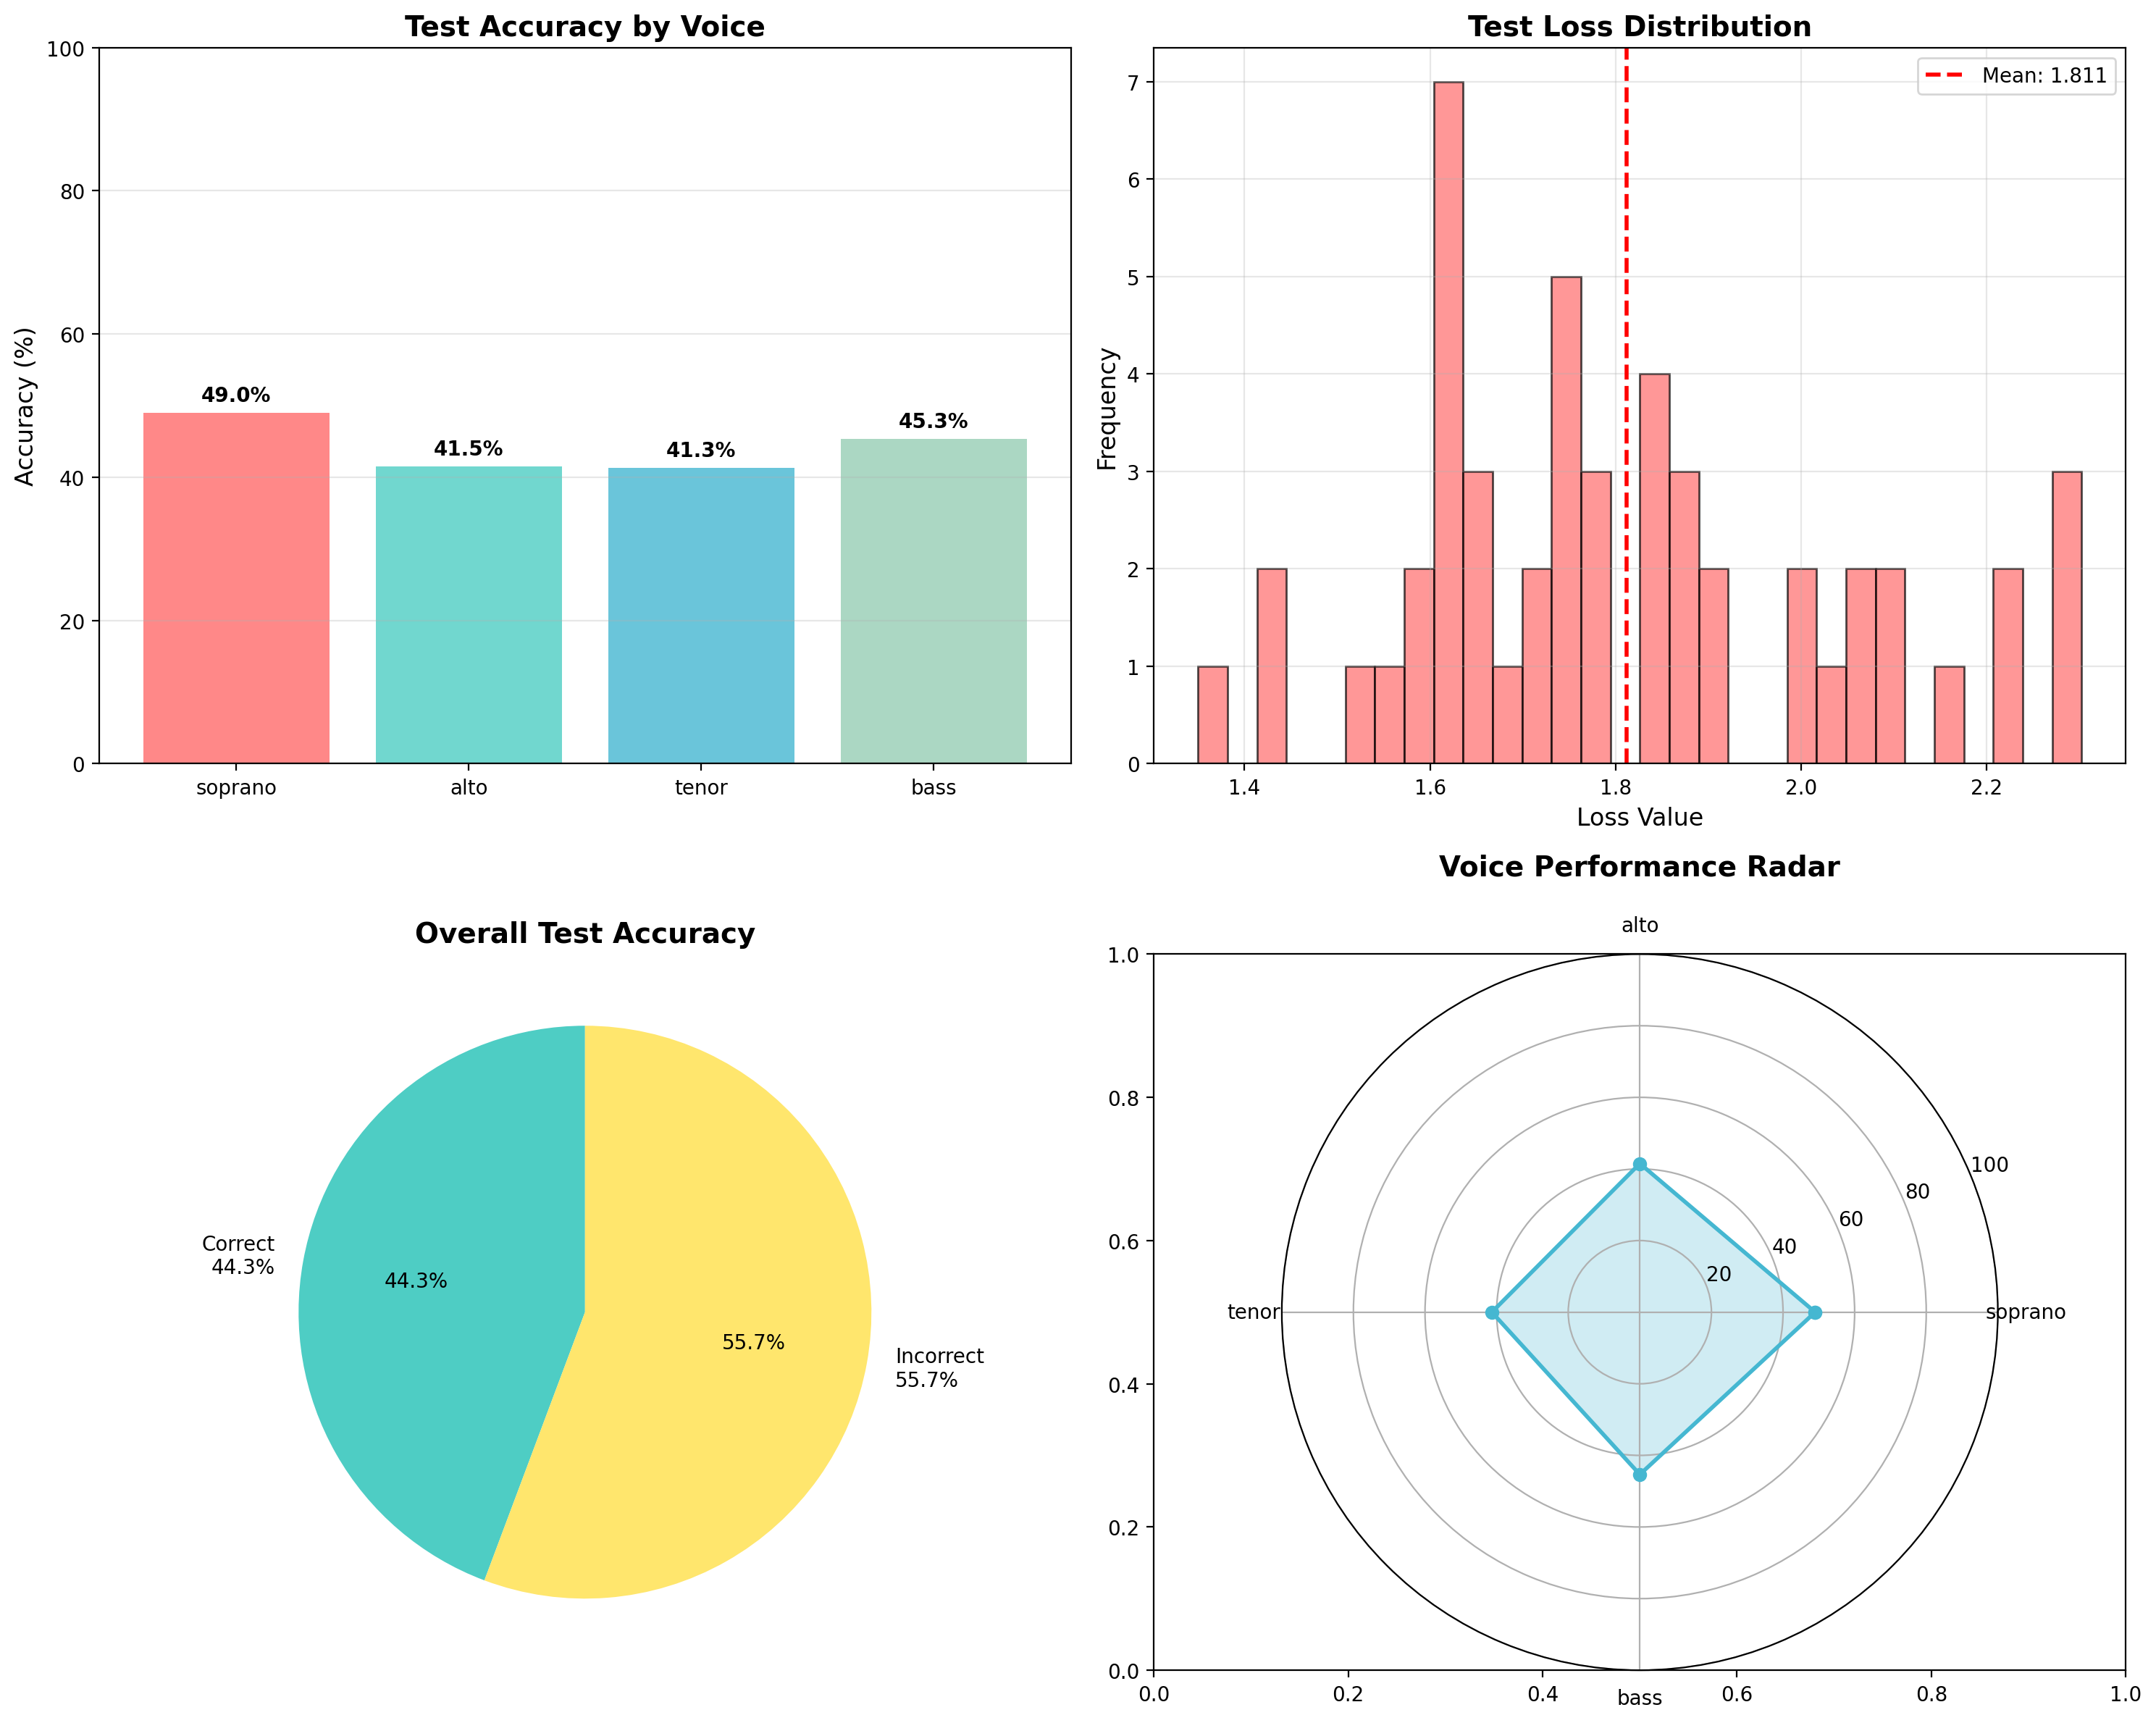

 Performance charts saved: outputs/evaluation_results/baseline_results.png

 Generation completed!
 MIDI files saved in: outputs/generated_chorales/baseline
 Charts saved in: outputs/evaluation_results/

--- CNN ---
=== CNN Unconditioned Music Generation ===
Using device: cpu
Loaded vocabulary from models/baseline_vocab.pkl
Vocabulary loaded: 67 notes
Loading model from models/cnn_model.pth
Detected model type: CNN
Saved model vocab size: notes=67
Current vocab size: notes=67
Vocabulary sizes match - loading model normally
 CNN model loaded successfully!
Model parameters: 798,092
Model accuracy: 0.863 (86.3%)

 Evaluating model on 56 test samples...
Evaluating model on 50 test samples...
  Evaluated 10/50 samples
  Evaluated 20/50 samples
  Evaluated 30/50 samples
  Evaluated 40/50 samples
  Evaluated 50/50 samples
Evaluation completed!
  Soprano: 0.849
  Alto: 0.877
  Tenor: 0.855
  Bass: 0.776
  Average Loss: 0.775

🎵 Generating samples with CNN model...

Sample 1 ({'length': 16, 'sa

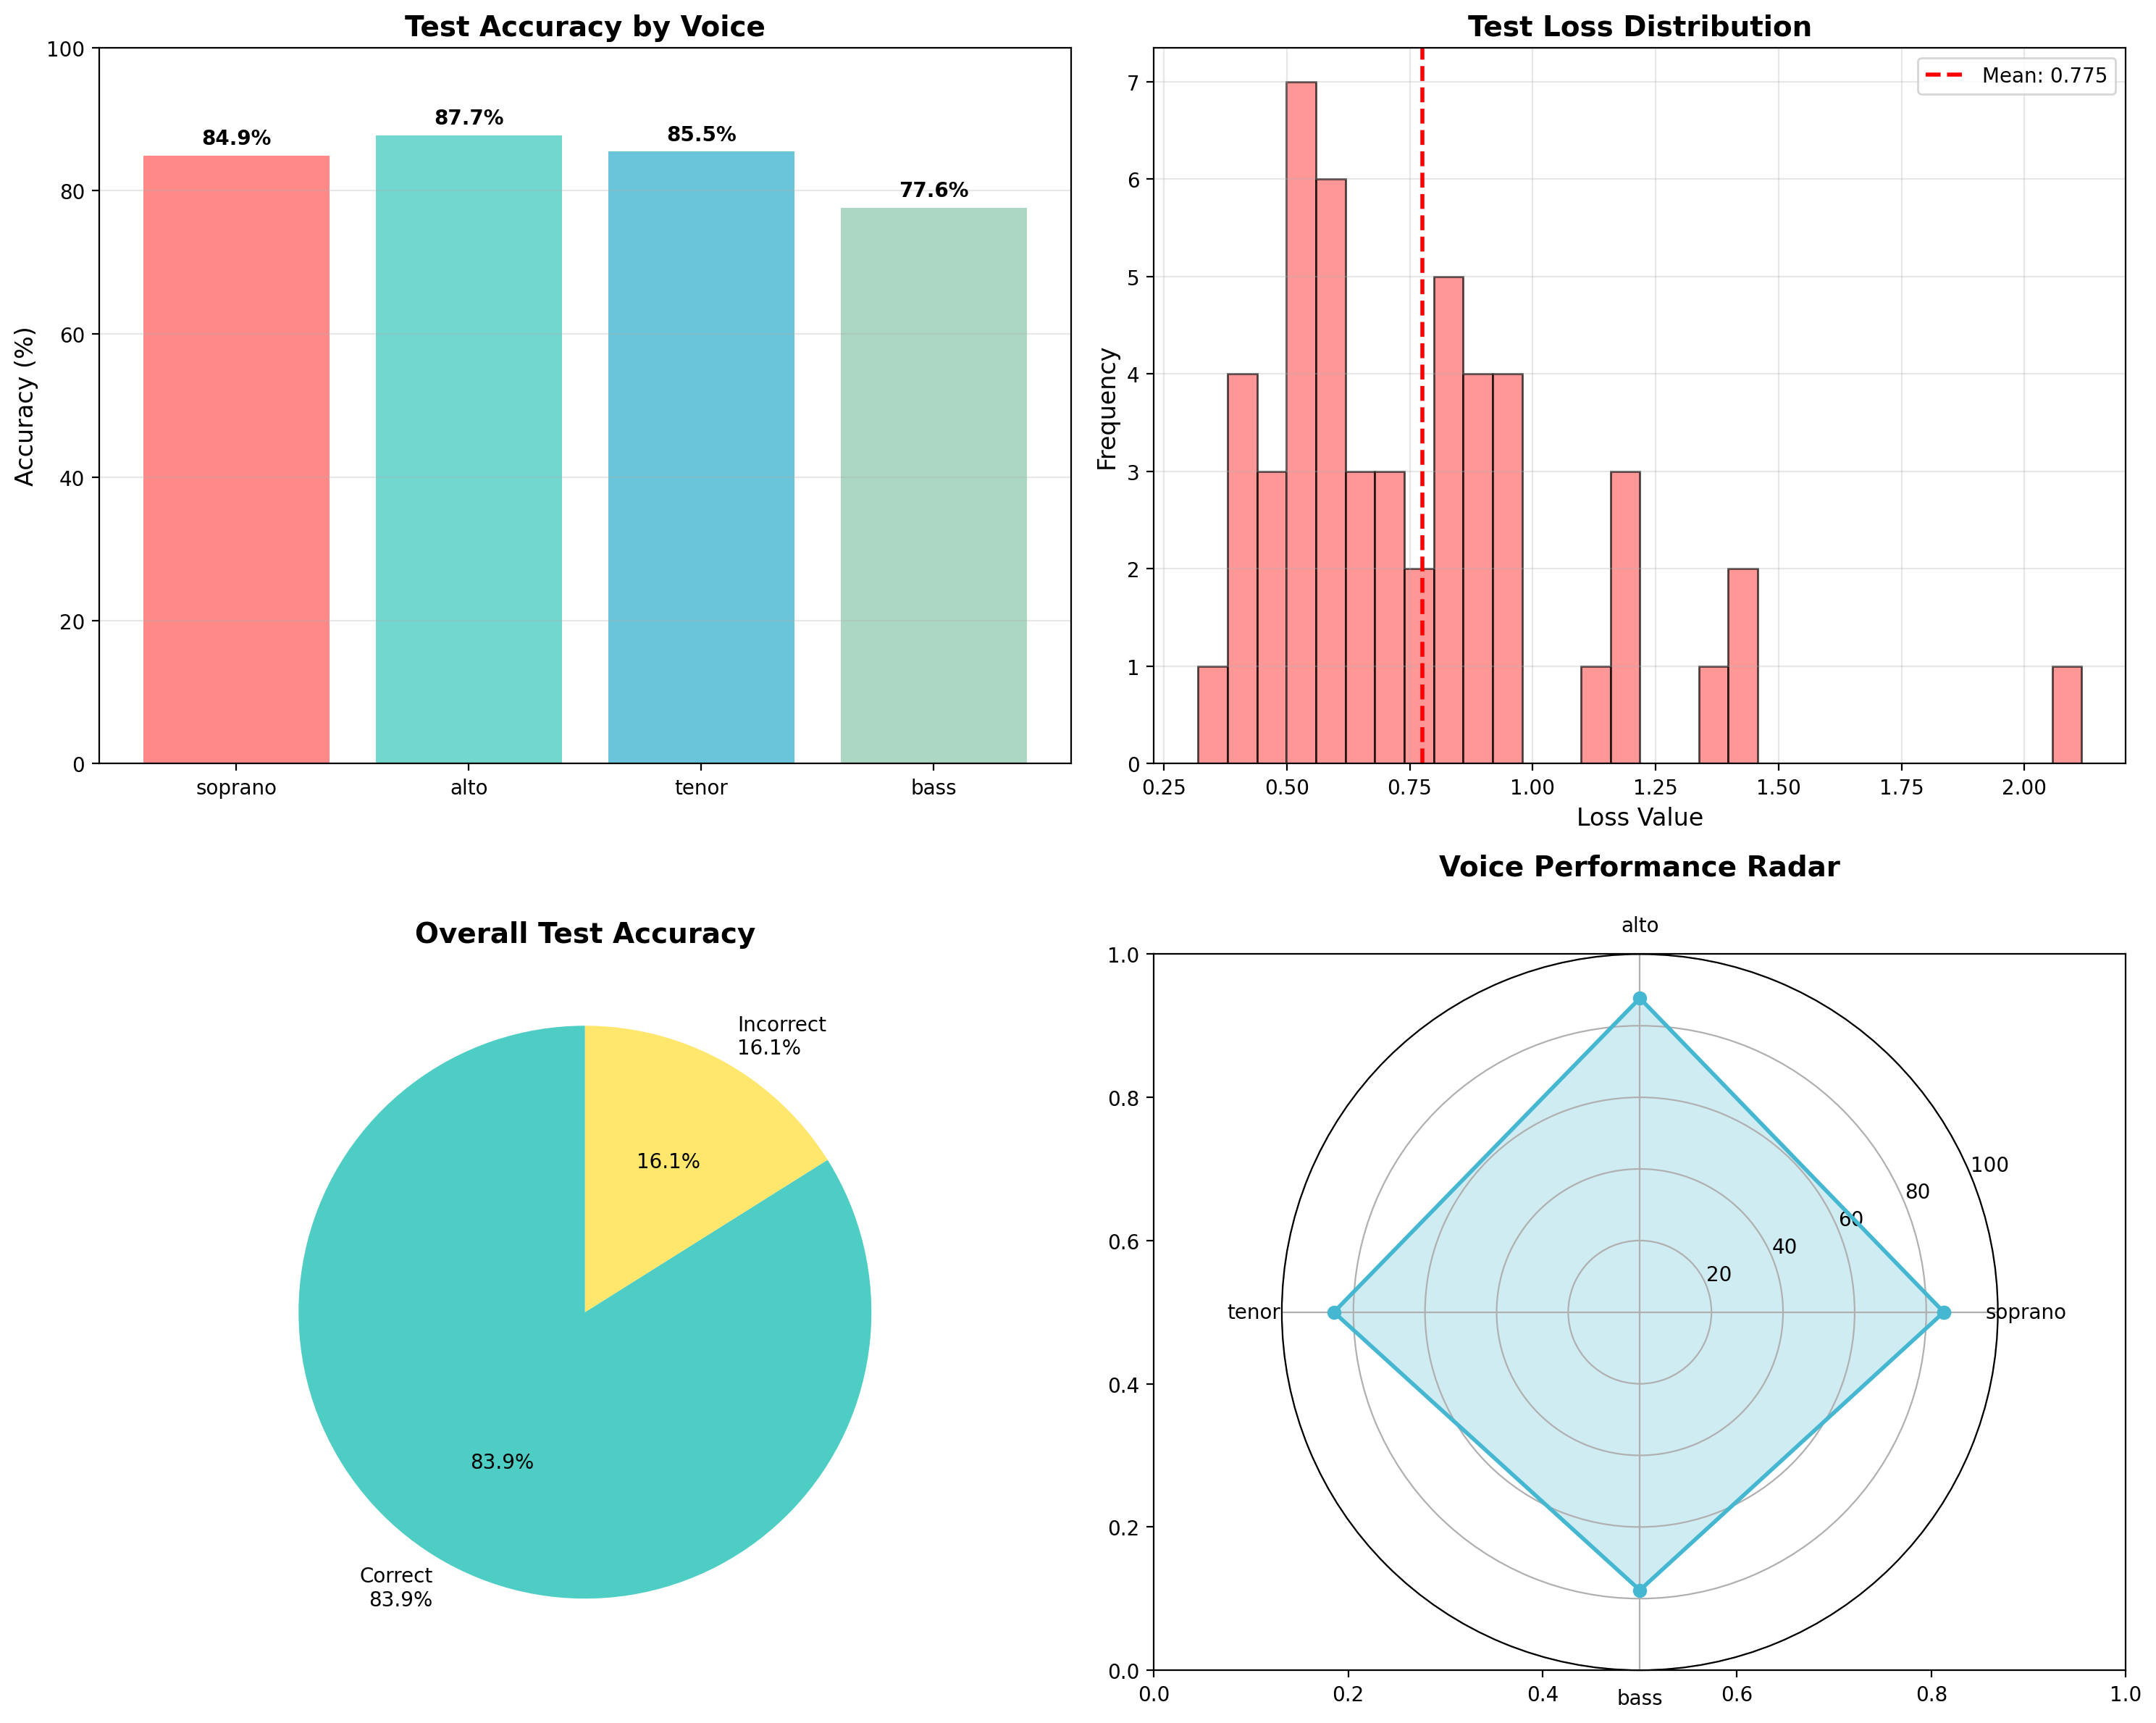

 Performance charts saved: outputs/evaluation_results/cnn_results.png

 Generation completed!
 MIDI files saved in: outputs/generated_chorales/cnn
 Charts saved in: outputs/evaluation_results/

--- N-gram ---
=== N-gram Unconditioned Music Generation ===
Using device: cpu
Loaded vocabulary from models/baseline_vocab.pkl
Vocabulary loaded: 67 notes
Loading model from models/ngram_model.pth
Detected model type: N-gram
Saved model vocab size: notes=67
Current vocab size: notes=67
Vocabulary sizes match - loading model normally
 N-gram model loaded successfully!
Model parameters: 49,795
Model accuracy: 0.413 (41.3%)

 Evaluating model on 56 test samples...
Evaluating model on 50 test samples...
  Evaluated 10/50 samples
  Evaluated 20/50 samples
  Evaluated 30/50 samples
  Evaluated 40/50 samples
  Evaluated 50/50 samples
Evaluation completed!
  Soprano: 0.428
  Alto: 0.367
  Tenor: 0.408
  Bass: 0.425
  Average Loss: 2.019

🎵 Generating samples with N-gram model...

Sample 1 ({'length': 1

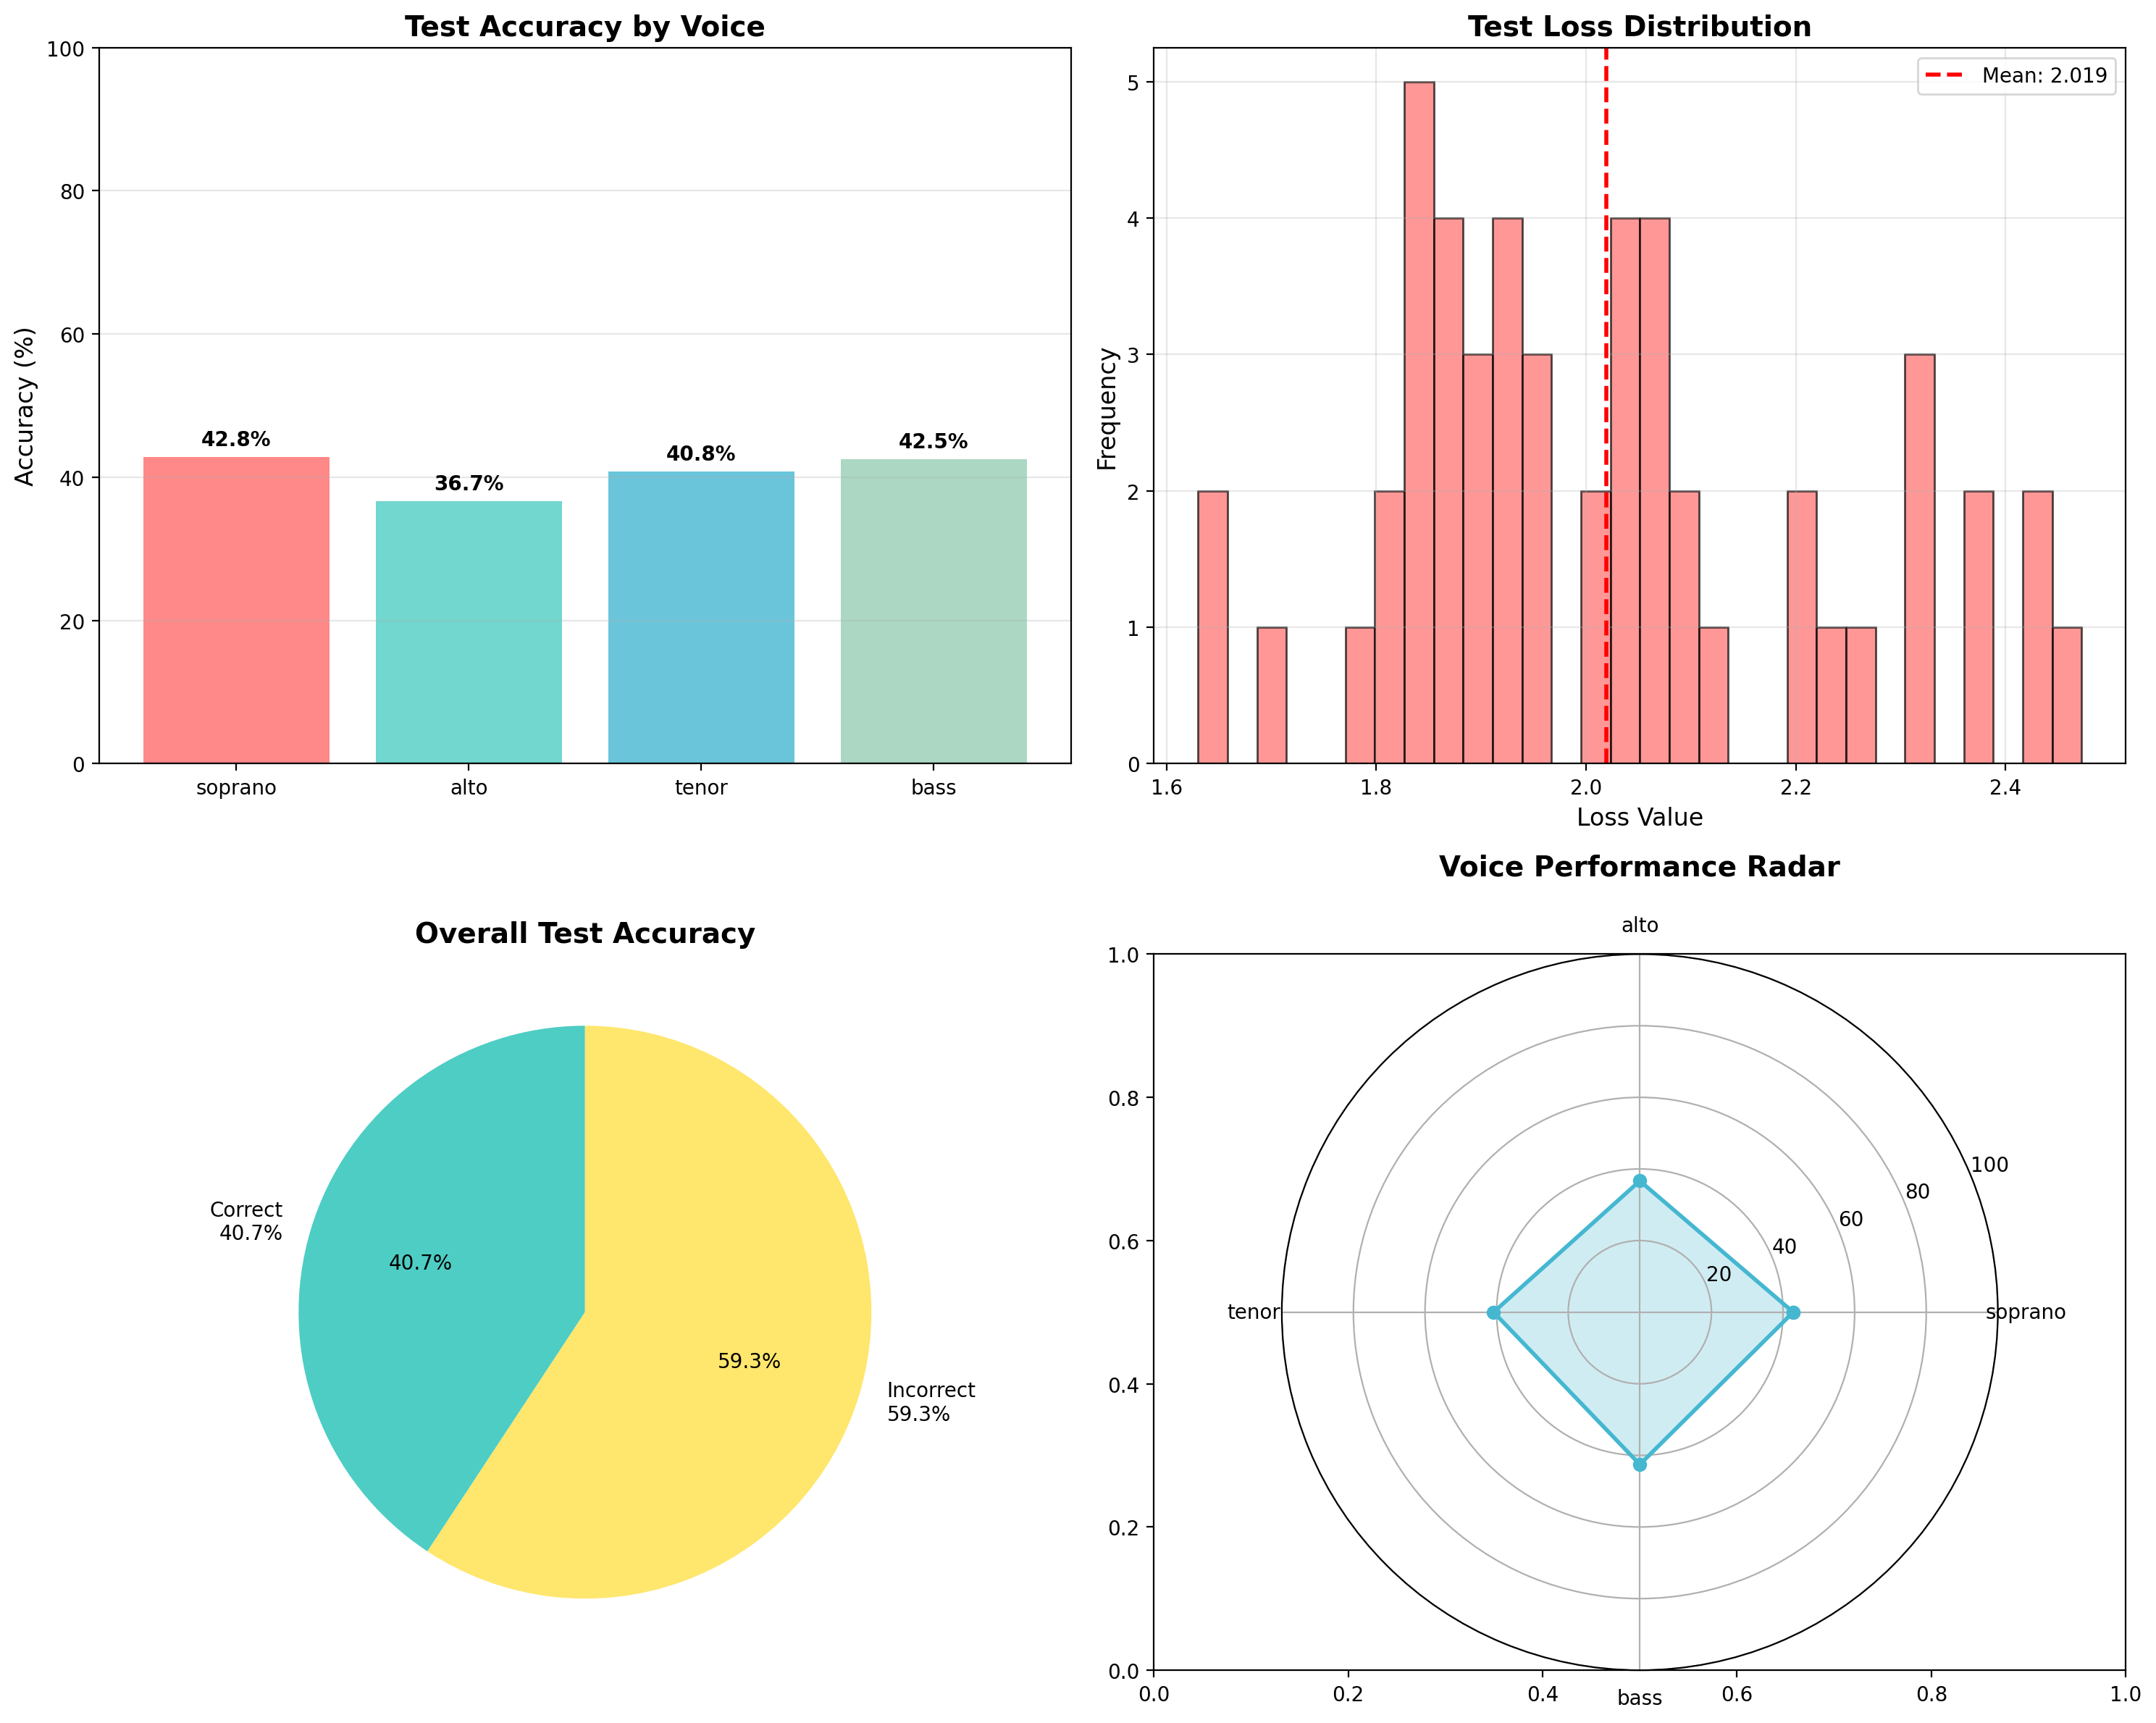

 Performance charts saved: outputs/evaluation_results/n-gram_results.png

 Generation completed!
 MIDI files saved in: outputs/generated_chorales/n-gram
 Charts saved in: outputs/evaluation_results/


In [11]:
# Display current model status
def show_model_status():
    print("\n=== Model Status ===")
    
    models = [
        ("models/baseline_model.pth", "Baseline"),
        ("models/cnn_model.pth", "CNN"),
        ("models/ngram_model.pth", "N-gram")
    ]
    
    found_models = []
    for path, name in models:
        if os.path.exists(path):
            print(f"[FOUND] {name}: {path}")
            found_models.append((path, name))
        else:
            print(f"[MISSING] {name}: not found")
    
    if os.path.exists(Config.RAW_JSON):
        print(f"[FOUND] Data: {Config.RAW_JSON}")
    else:
        print(f"[MISSING] Data: not found")
    print()
    
    return found_models

# main entrance
def main():
    print("=== Unconditioned Four-Part Choir Generation System ===")
    print("1. Convert XML to JSON")
    print("2. Train Model")
    print("3. Test and Generate")
    print("4. Full Pipeline")
    
    choice = input("Choose option (1-4): ").strip()
    create_folders()
    
    if choice == "1":
        # Data conversion
        print("Converting XML files...")
        convert_xml_to_json()
        
    elif choice == "2":
        # Train models
        if not os.path.exists(Config.RAW_JSON):
            print(f"Data file does not exist: {Config.RAW_JSON}")
            print("Please run option 1 to convert data first")
            return
        
        print("\n=== Training Options ===")
        print("1. Baseline Model (LSTM)")
        print("2. Non-LSTM Models (CNN/N-gram)")
        
        train_choice = input("Choose (1/2): ").strip().lower()
        
        if train_choice == "1":
            train_baseline_model()
        elif train_choice == "2":
            train_advanced_model()
        else:
            print("Invalid choice")
    
    elif choice == "3":
        # Test and generate
        found_models = show_model_status()
        
        if not found_models:
            print("No trained models found. Please train a model first.")
            return
        
        if len(found_models) == 1:
            # Only one model available
            model_path, model_name = found_models[0]
            print(f"Testing {model_name} model...")
            test_and_generate_universal(model_path, model_name)
        else:
            # Multiple models available
            print("\n=== Choose Model ===")
            for i, (path, name) in enumerate(found_models):
                print(f"{i+1}. {name}")
            print(f"{len(found_models)+1}. Test all models")
            
            model_choice = input(f"Choose (1-{len(found_models)+1}): ").strip()
            
            try:
                idx = int(model_choice) - 1
                if 0 <= idx < len(found_models):
                    model_path, model_name = found_models[idx]
                    print(f"Testing {model_name} model...")
                    test_and_generate_universal(model_path, model_name)
                elif idx == len(found_models):
                    print("Testing all models...")
                    for model_path, model_name in found_models:
                        print(f"\n--- {model_name} ---")
                        test_and_generate_universal(model_path, model_name)
                else:
                    print("Invalid choice")
            except ValueError:
                print("Please enter a number")
    
    elif choice == "4":
        # Full pipeline
        print("\n=== Full Pipeline Options ===")
        print("1. Baseline Pipeline")
        print("2. Non-LSTM Pipeline")
        
        pipeline_choice = input("Choose (1/2): ").strip().lower()
        
        print("Starting full pipeline...")
        
        # Convert data first
        if not convert_xml_to_json():
            print("Data conversion failed, stopping pipeline")
            return
        
        if pipeline_choice == "1":
            print("\n--- Baseline Full Pipeline ---")
            train_baseline_model()
            if os.path.exists("models/baseline_model.pth"):
                test_and_generate_baseline()
            
        elif pipeline_choice == "2":
            print("\n--- Non-LSTM Full Pipeline ---")
            train_advanced_model()
            
            # Find and test the trained model
            non_lstm_models = [
                ("models/cnn_model.pth", "CNN"),
                ("models/ngram_model.pth", "N-gram")
            ]
            
            for model_path, model_name in non_lstm_models:
                if os.path.exists(model_path):
                    print(f"\n--- Testing {model_name} ---")
                    test_and_generate_universal(model_path, model_name)
                    break
        else:
            print("Invalid choice")
        print("\nFull pipeline completed successfully")
    else:
        print("Invalid choice, please select 1-4")

if __name__ == "__main__":
    show_model_status()
    main()